In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import processing
from utils import utils

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (18,10)

In [3]:
kld = pd.read_csv('../data/processed/kolding_features.csv', index_col='Datetime', parse_dates=['Datetime'])
stb = pd.read_csv('../data/processed/kolding_features.csv', index_col='Datetime', parse_dates=['Datetime'])

In [4]:
# Processing Parameters
split = 0.80 # split percentage for training data
steps = 1 # timesteps: 1 hour

lookback = 24 * 7 # the number of hours in the past the model is shown
horizon = 1 # the target hour in the future we want to predict 1 hour ahead

# Training parameters
batch_size = 256
epochs = 50
lr = 0.001

In [5]:
# Create Train, Val, and Test Sets
kld_train, kld_val, kld_test = processing.create_datasets(kld, split=split, steps=steps, lookback=lookback,
                                                          horizon=horizon, batch_size=batch_size, scaler='standard')
stb_train, stb_val, stb_test = processing.create_datasets(stb, split=split, steps=steps, lookback=lookback,
                                                          horizon=horizon, batch_size=batch_size, scaler='standard')

In [6]:
for batch in kld_train.take(1):
    inputs, targets = batch
    
print(f"Input Shape: {inputs.numpy().shape}")
print(f"Target Shape: {targets.numpy().shape}")

Input Shape: (256, 168, 7)
Target Shape: (256, 1)


In [7]:
# Stacked LSTM
LSTM_base = Sequential()

LSTM_base.add(LSTM(64, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2])))
LSTM_base.add(Dropout(0.25))
LSTM_base.add(LSTM(128, return_sequences=False))
LSTM_base.add(Dropout(0.25))
LSTM_base.add(Dense(1))

LSTM_base.compile(optimizer=Adam(learning_rate=lr), loss="mse")

LSTM_base.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 168, 64)           18432     
_________________________________________________________________
dropout (Dropout)            (None, 168, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 117,377
Trainable params: 117,377
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Callbacks
ckpt_path = "../model/models/LSTM_base.h5"
estp = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

ckpt = ModelCheckpoint(
    monitor='val_loss',
    filepath=ckpt_path,
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)

In [9]:
history = LSTM_base.fit(
    kld_train,
    epochs=epochs,
    validation_data=kld_val,
    callbacks=[estp, ckpt]
)

Epoch 1/50
60/60 [==============================] - 59s 890ms/step - loss: 0.9690 - val_loss: 0.9471

Epoch 00001: val_loss improved from inf to 0.94705, saving model to ../model/models\LSTM_base.h5
Epoch 2/50
60/60 [==============================] - 48s 808ms/step - loss: 0.6363 - val_loss: 0.8254

Epoch 00002: val_loss improved from 0.94705 to 0.82537, saving model to ../model/models\LSTM_base.h5
Epoch 3/50
60/60 [==============================] - 48s 796ms/step - loss: 0.5752 - val_loss: 1.0455

Epoch 00003: val_loss did not improve from 0.82537
Epoch 4/50
60/60 [==============================] - 49s 822ms/step - loss: 0.5685 - val_loss: 0.9184

Epoch 00004: val_loss did not improve from 0.82537
Epoch 5/50
60/60 [==============================] - 51s 856ms/step - loss: 0.5117 - val_loss: 0.5532

Epoch 00005: val_loss improved from 0.82537 to 0.55320, saving model to ../model/models\LSTM_base.h5
Epoch 6/50
60/60 [==============================] - 52s 872ms/step - loss: 0.3624 - val_l

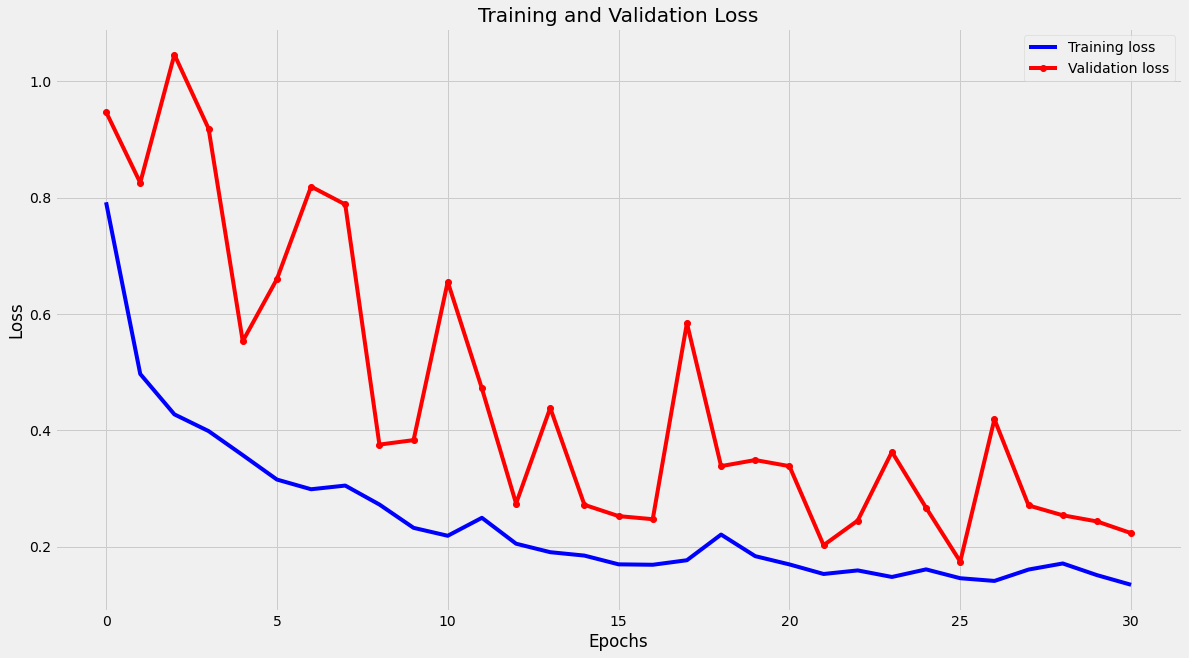

In [10]:
utils.plot_training(history, "Training and Validation Loss")

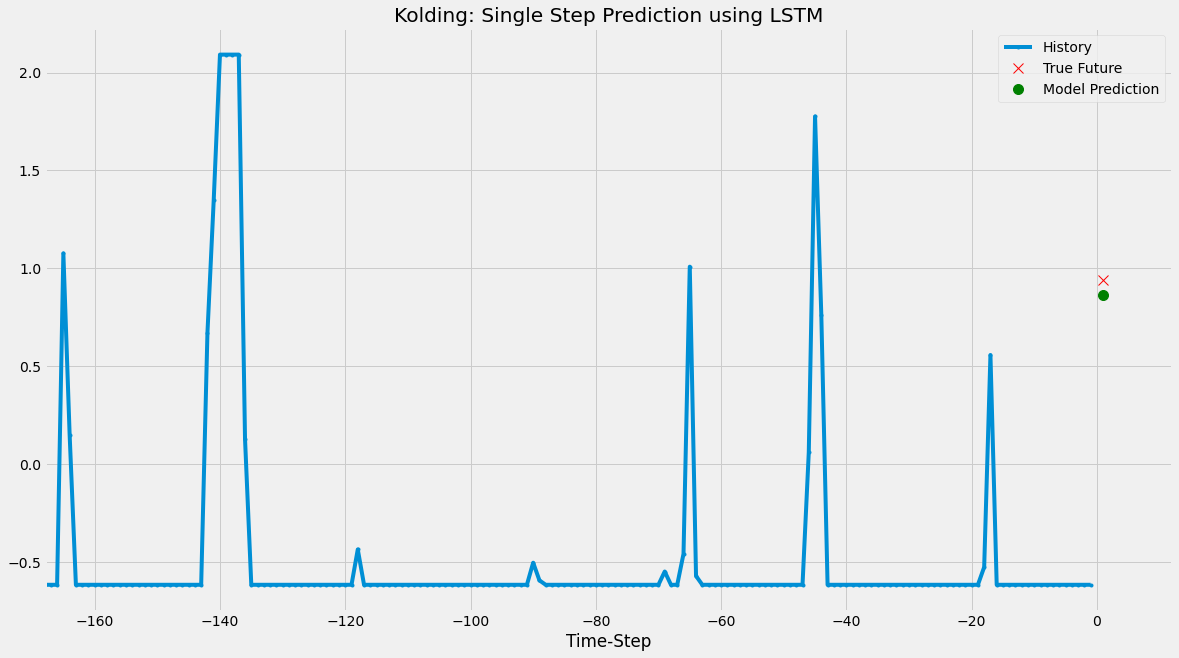

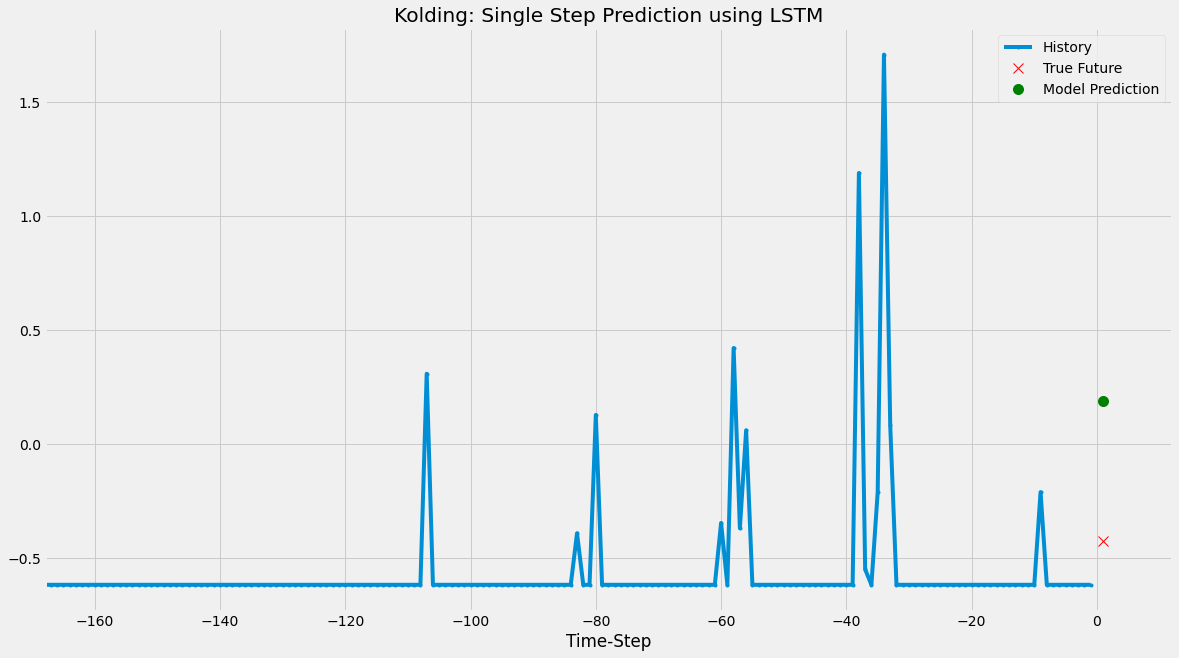

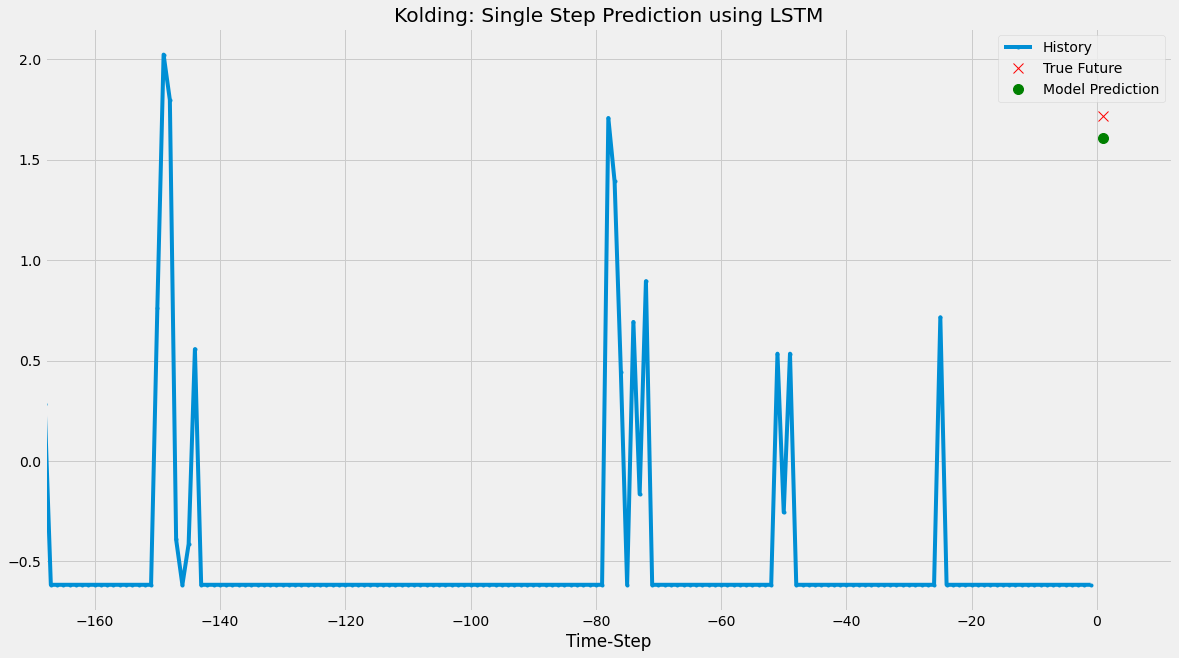

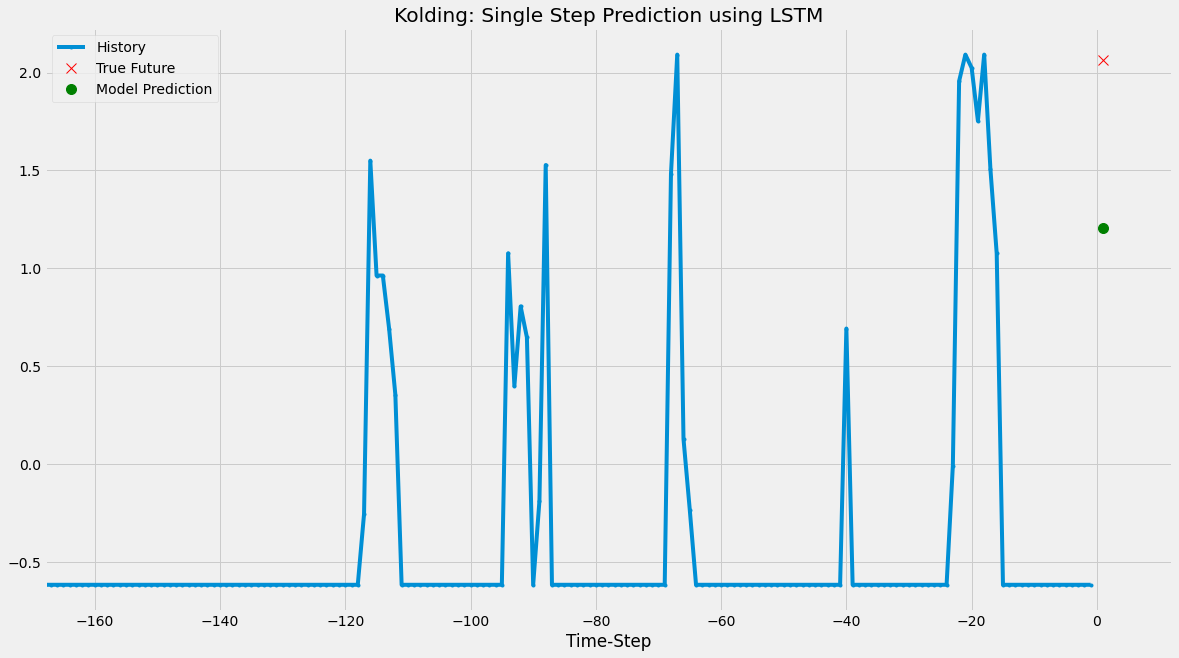

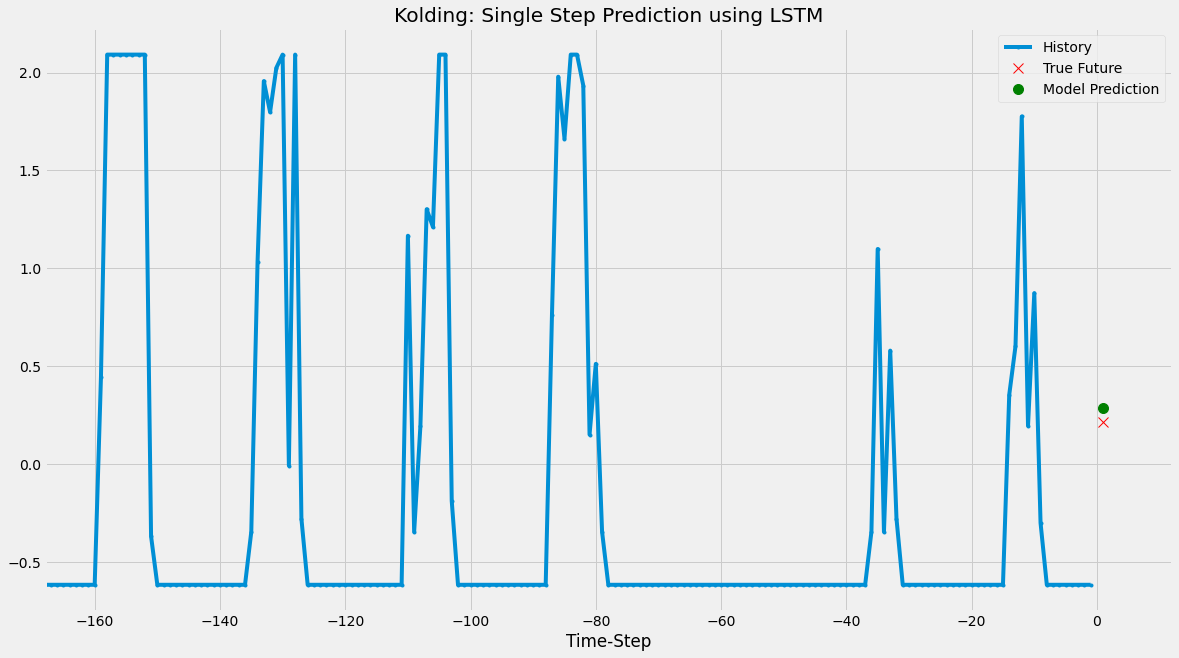

In [11]:
# Predictions
for x, y in kld_test.take(5):
    utils.plot_pred(
        [x[0][:, 1].numpy(), y[0].numpy(), LSTM_base.predict(x)[0]],
        1,
        "Kolding: Single Step Prediction using LSTM",
    )

